# Image Offsets - Centroid precision analysis

Tables generated by the previous notebook (Offsets_2) are used to build some statistics associated with centroiding. 

This is a crucial step in drizzle implementation, since we must assure that the pixel offsets created by this process have sufficient precision to even justify drizzling in the first place. Remember that we are using Bayer RGB raw arrays as a source for centroiding, so color effects may be of importance here.

This script also provides the means to reject stars with large residuals in centroid position.

Originally this notebook was developed with the ISO 12800 data set as the test data. In the current version, it is configured to use a different data set. Statements specific to the original data set were comented out.

In [1]:
import os, glob
import random
import math

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table
from photutils.aperture import CircularAperture
import rawpy

from datapath import DATA

## Read tables created by previous notebook

In [2]:
# datadir = os.path.join(DATA,'astrophotography_data/MilkyWayPrettyBoy/12800/light/')   # ISO 12800 data set
# datadir = os.path.join(DATA,'astrophotography_data/MilkyWayPrettyBoy/6400/light/')    # ISO 6400 data set
datadir = os.path.join(DATA,'astrophotography_data/Andromeda_2022/135mm1s3200ISO/')    # Andromeda data set

file_list = glob.glob(datadir + '*.offsets_table.fits')
file_list.sort()

# file_list = list(reversed(file_list))   # ISO 6400 data set

table_list = [Table.read(x) for x in file_list]

## Read image to get array size

In [3]:
# # last table in sequence
# last = file_list[-1]

# # prototype image
# image_name = last.split('/')[-1]
# image_name = image_name.replace('.offsets_table.fits', '.ARW')
# image_name = os.path.join(datadir, image_name)
# raw = rawpy.imread(image_name)
# imarray = raw.raw_image_visible.astype(float)

# ny = imarray.shape[0]
# nx = imarray.shape[1]

# print(nx, ny)

In [4]:
# last table in sequence
last = file_list[-1]

# prototype image
image_name = last.split('/')[-1]
image_name = image_name.replace('.offsets_table.fits', '.cutout.fits')
image_name = os.path.join(datadir, image_name)
f = fits.open(image_name)
imarray = f[1].data
f.close()    

ny = imarray.shape[0]
nx = imarray.shape[1]

print(nx, ny)

2300 2710


## Functions

These functions plot centroids (Y against X) as a function of time (or image number in sequence) to gauge the precision to which we can recover the centroid from the highly under-sampled data.

In [5]:
# gets row index of star nearest to the supplied coordinates. 
def get_nearest_index(x, y, table):
    min_dist = math.sqrt(float(nx)**2 + float(ny)**2)
    row_index_min_dist = 0

    for row_index in range(len(table)):
        xcent = table['xcentroid'][row_index]
        ycent = table['ycentroid'][row_index]
        
        dist = math.sqrt((x - xcent)**2 + (y - ycent)**2)
        
        if (dist < min_dist):
            min_dist = dist
            row_index_min_dist = row_index

    return row_index_min_dist

In [6]:
# fits a straight line thru centroids and compute residuals
def fit_line(table_list, input_row_index):
    row_index = input_row_index

    # collect all centroid measurements of the given star
    x_data = []
    y_data = []
    for table_object in reversed(table_list):
    
        x_data.append(table_object['xcentroid'][row_index])
        y_data.append(table_object['ycentroid'][row_index])

        # update row index to point to previous' table row that 
        # corresponds to this star.
        row_index = table_object['prev_row'][row_index]

    # fit straight line and compute residuals
    x_data = np.asarray(x_data)
    y_data = np.asarray(y_data)

    slope, intercept, r_value, p_value, std_err = stats.linregress(x_data, y_data)

    pred_values = slope * x_data + intercept
    residuals = y_data - pred_values
    stdev = math.sqrt(np.sum(residuals**2) / len(residuals))
    
    return stdev, slope, intercept, x_data, y_data, residuals

In [7]:
def plot_residuals(x, y, table_list, nearest=False, large_resid=None):

    # last table in sequence 
    table_last = table_list[-1]

    # find in last table, the row corresponding to the input star, 
    # based on centroid column.
    tol = 2.0 # tolerance

    # we assume first, that the x,y coordinates are exact, that is,
    # they match within a tolerance, an existing table row.
    found = False
    for row_index in range(len(table_last)):
        xcent = table_last['xcentroid'][row_index]
        ycent = table_last['ycentroid'][row_index]

        if (abs(x - xcent) < tol and abs( y - ycent) < tol):
            found = True
            break

    # if no row with matching x,y centroids can be found, we can either
    # pick any row at random, or look for the nearest centroid to the 
    # given x,y position.
    if not found:
        if nearest:
            print("Coordinates: ", x, y, ". Picking nearest star.")
            row_index = get_nearest_index(x, y, table_last)
        else:
            print("Cannot find star near ", x, y, ". Picking at random.")
            row_index = random.randrange(len(table_last))

        x = table_last['xcentroid'][row_index]
        y = table_last['ycentroid'][row_index]

    # fit line
    stdev, slope, intercept, x_data, y_data, residuals = fit_line(table_list, row_index)
    
    # plot
    if large_resid is None or (large_resid is not None and stdev > large_resid):
        fig, (ax1, ax2) = plt.subplots(1, 2)
    #     fig.set_size_inches(8.5, 3.5) # interactive notebook
        fig.set_size_inches(12.5, 5.5)

        for xp,yp,r in zip(x_data, y_data, residuals):
            ax1.plot(xp, yp, 'ro')
            ax2.plot(xp, r, 'ro')

        title = 'x = {:.2f} y = {:.2f}'.format(x, y)
        sigma = '\u03C3 = {:.3f}'.format(stdev)

        ax1.grid()
        ax2.grid()
        ax1.set_title(title)
        ax2.set_title(sigma)

        fig.show()

These functions reject stars with large residuals, from all tables.

In [8]:
# keep only the NaN-free entries
def clean_nans(table):
    has_nan = np.zeros(len(table), dtype=bool)
    xoff = np.array(table['xcentroid'])
    has_nan |= np.isnan(xoff)
    return table[~has_nan]

In [9]:
def reject_stars(table_list, residual_threshold=0.6):

    # last table in sequence 
    table_last = table_list[-1]
    
    # scan rows in last table
    for last_table_row_index in range(len(table_last)):
        row_index = last_table_row_index

        # fit line for this star
        stdev, slope, intercept, _, _, _ = fit_line(table_list, row_index)

        if stdev > residual_threshold:
            print(last_table_row_index, stdev)
            
            # mark this star in all tables
            ri = last_table_row_index
            for table_object in reversed(table_list):
                table_object['xcentroid'][ri] = np.NaN
                ri = table_object['prev_row'][ri]

    # once all rows in all tables were marked, remove them.
    table_list_clean = []

    for table in table_list:
        table_list_clean.append(clean_nans(table))
        
    return table_list_clean

## Plot

The plots are in general consistent with precision of a fraction of one pixel. They seem to warrant the use of drizzle.

Coordinates:  500 500 . Picking nearest star.


/var/folders/y5/zcwj7zc17g19nggvb1vx4rc80000gn/T/ipykernel_2852/1678248329.py:56: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Coordinates:  500 1000 . Picking nearest star.
Coordinates:  500 1500 . Picking nearest star.
Coordinates:  500 2000 . Picking nearest star.
Coordinates:  500 2500 . Picking nearest star.
Coordinates:  1000 500 . Picking nearest star.
Coordinates:  1000 1000 . Picking nearest star.
Coordinates:  1000 1500 . Picking nearest star.
Coordinates:  1000 2000 . Picking nearest star.
Coordinates:  1000 2500 . Picking nearest star.
Coordinates:  1500 500 . Picking nearest star.
Coordinates:  1500 1000 . Picking nearest star.
Coordinates:  1500 1500 . Picking nearest star.
Coordinates:  1500 2000 . Picking nearest star.
Coordinates:  1500 2500 . Picking nearest star.
Coordinates:  2000 500 . Picking nearest star.
Coordinates:  2000 1000 . Picking nearest star.
Coordinates:  2000 1500 . Picking nearest star.
Coordinates:  2000 2000 . Picking nearest star.
Coordinates:  2000 2500 . Picking nearest star.


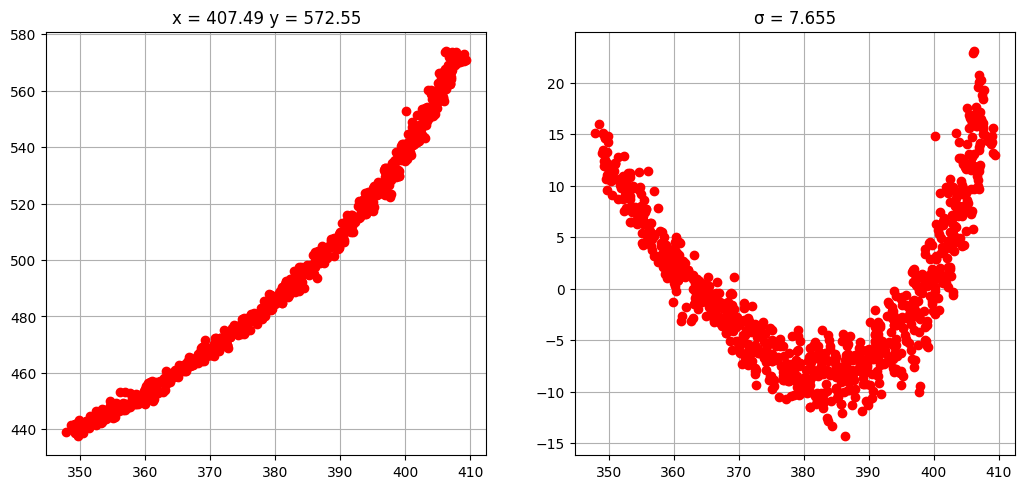

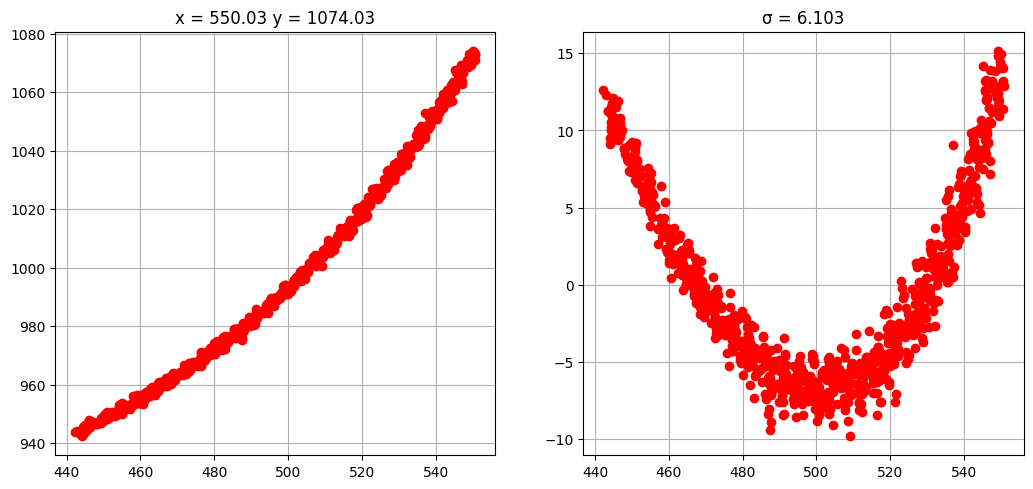

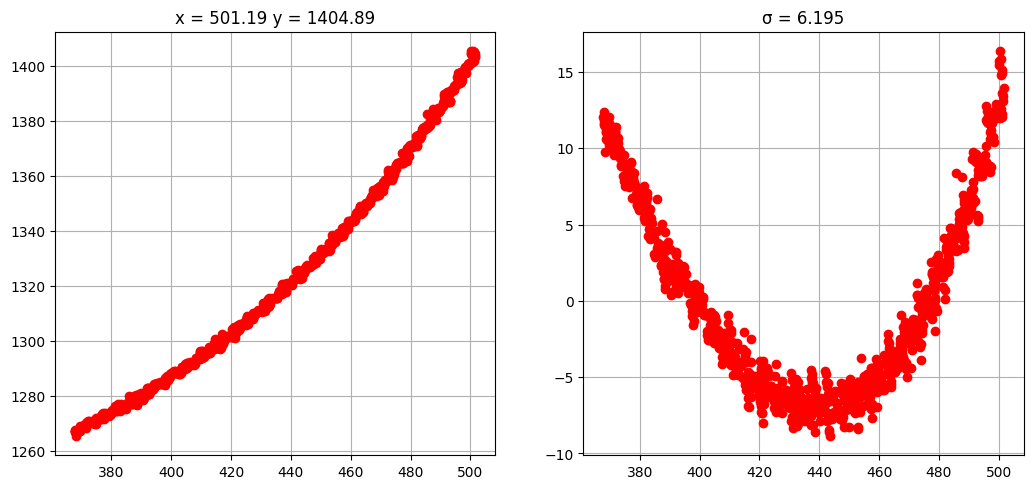

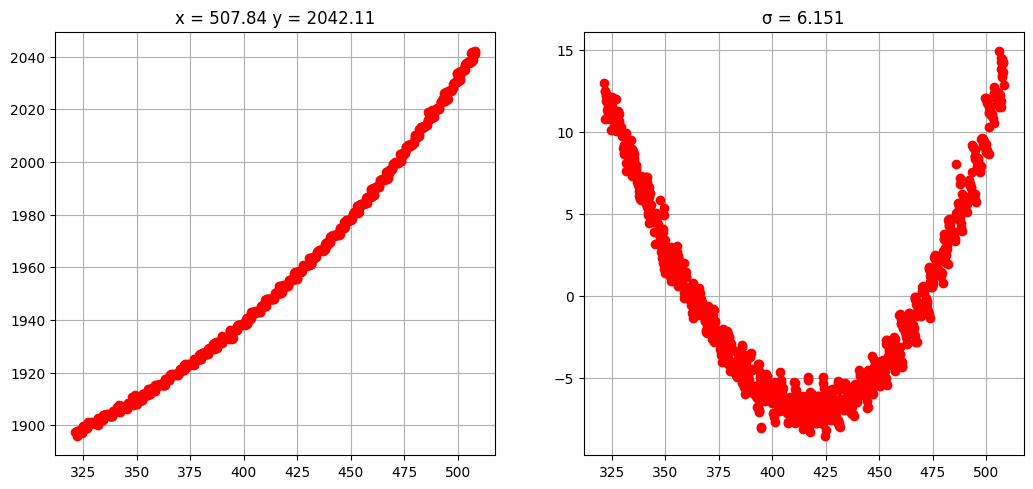

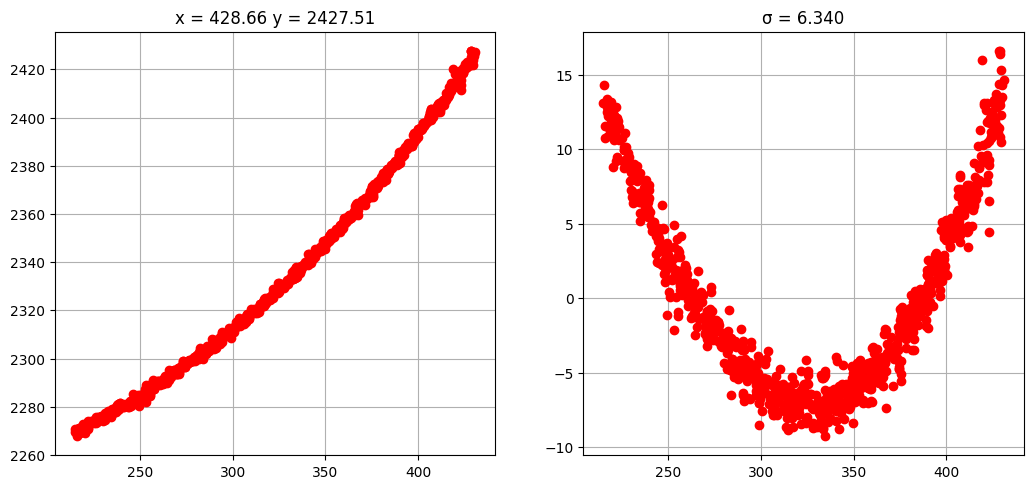

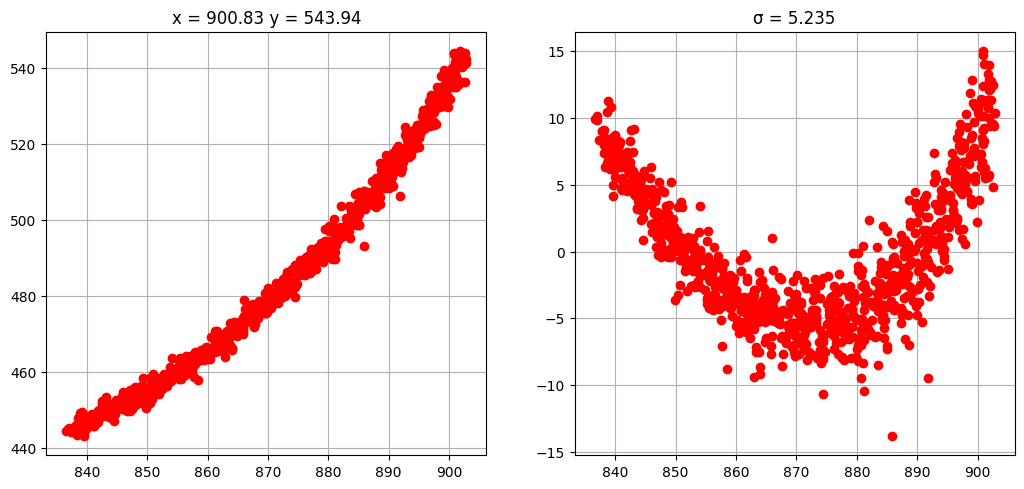

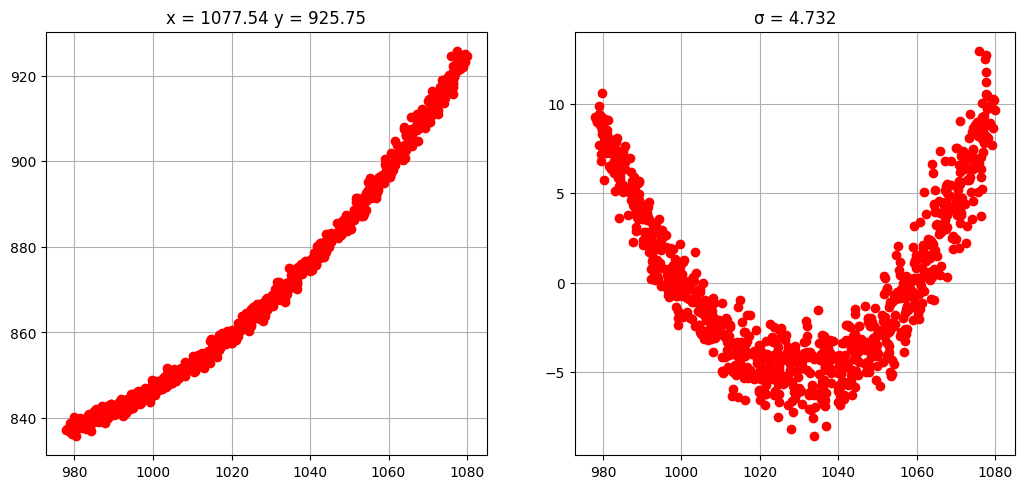

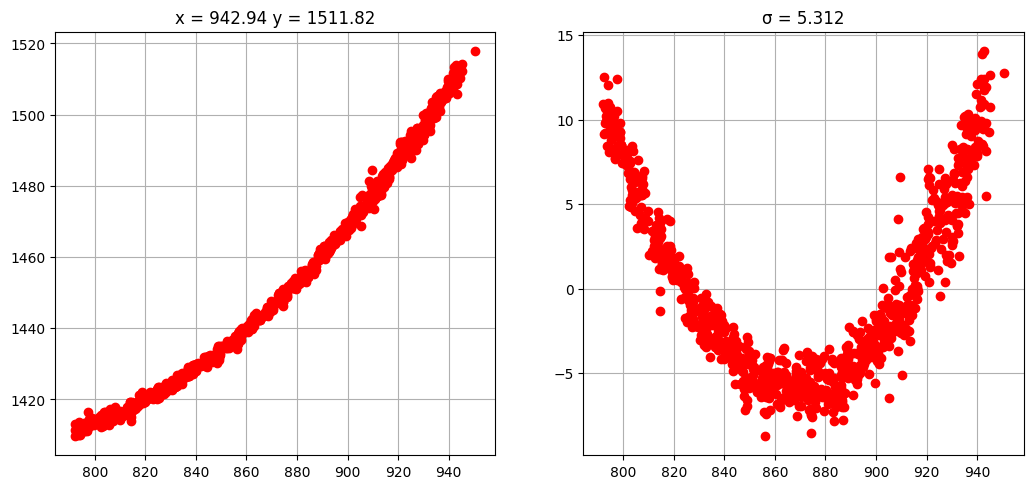

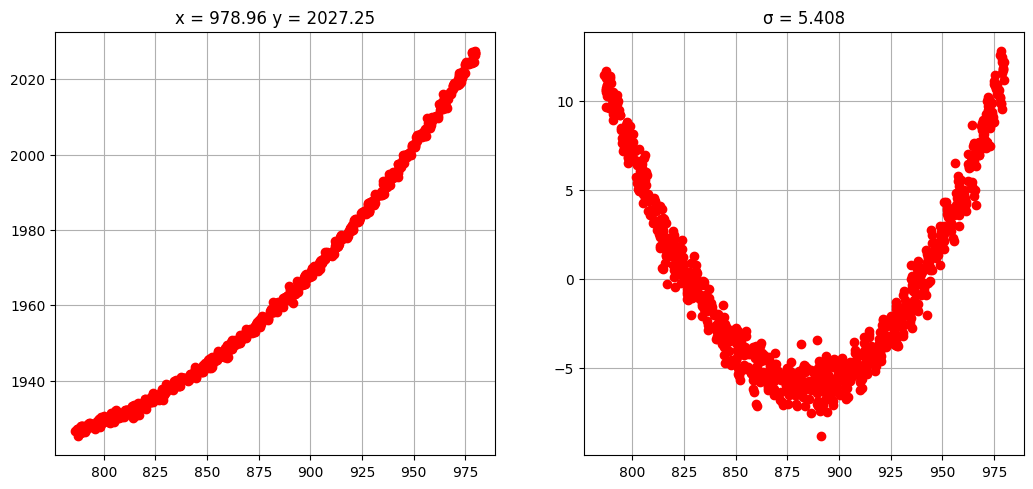

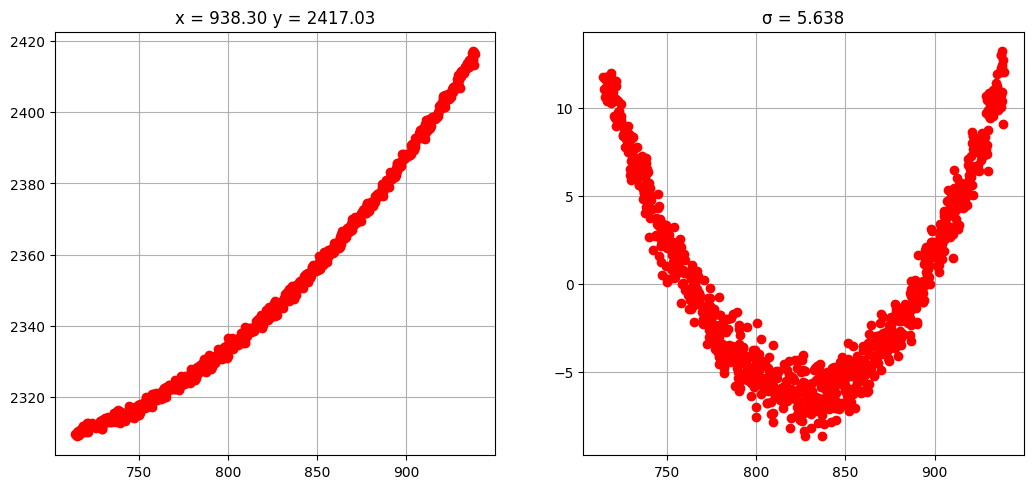

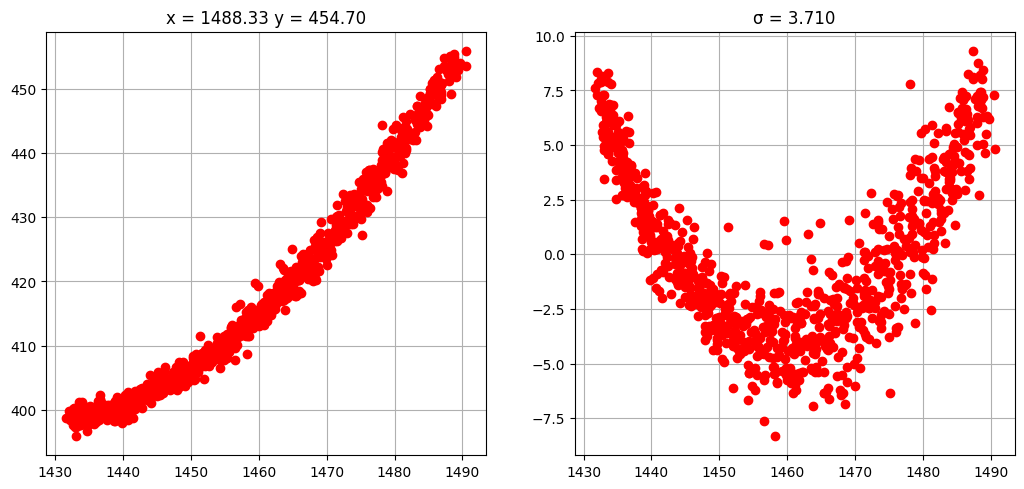

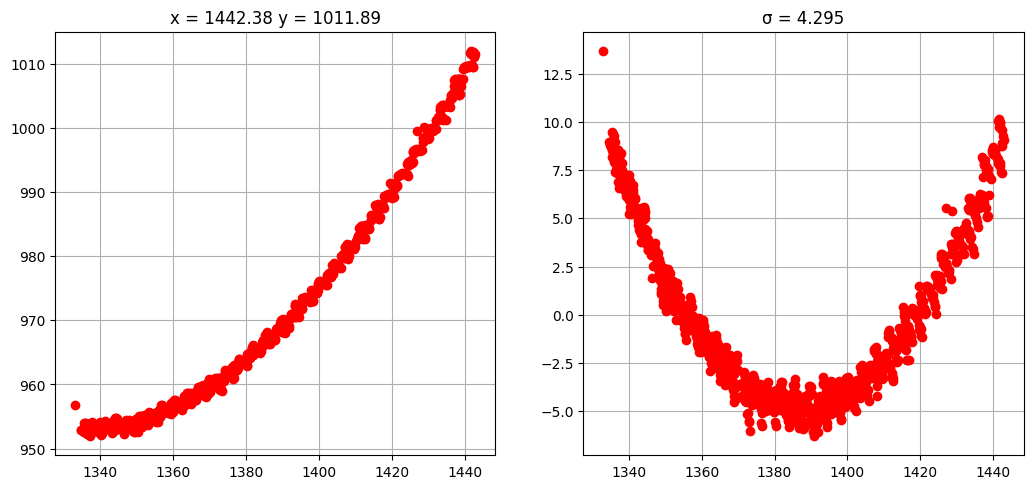

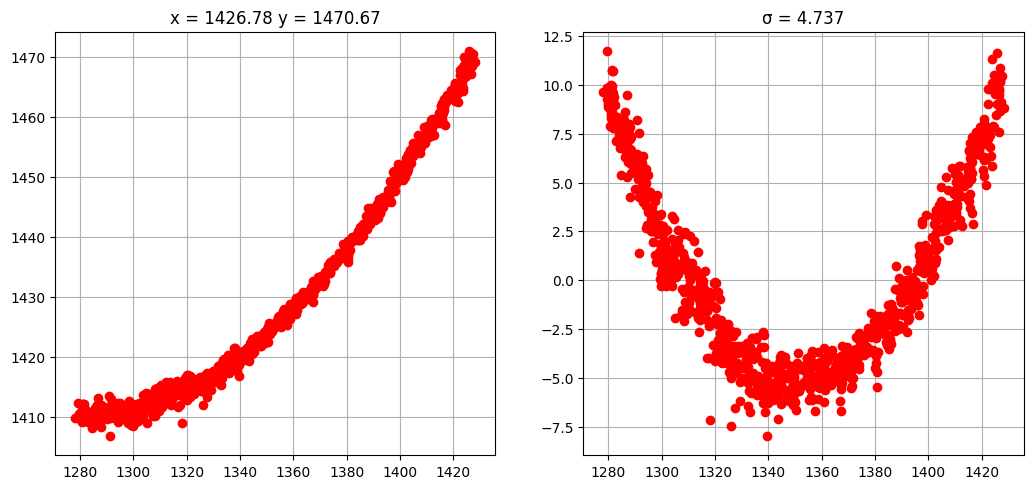

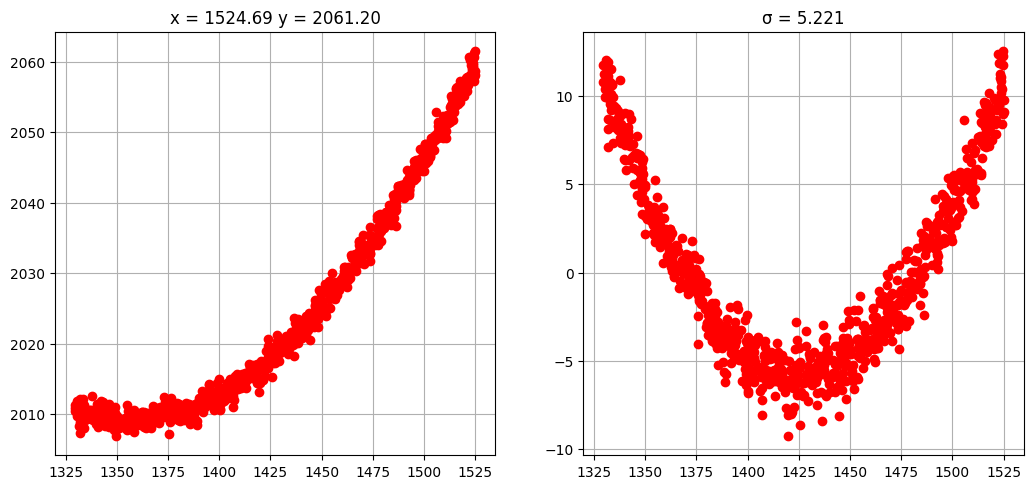

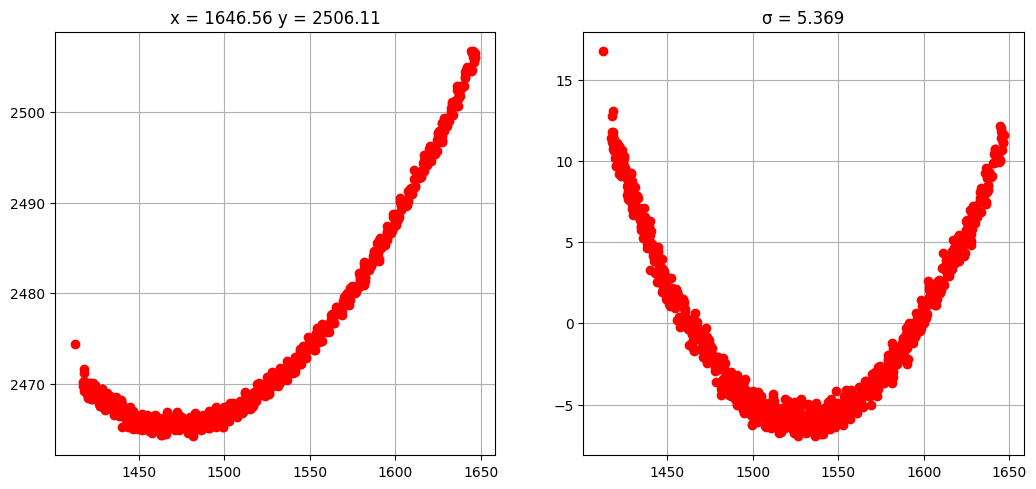

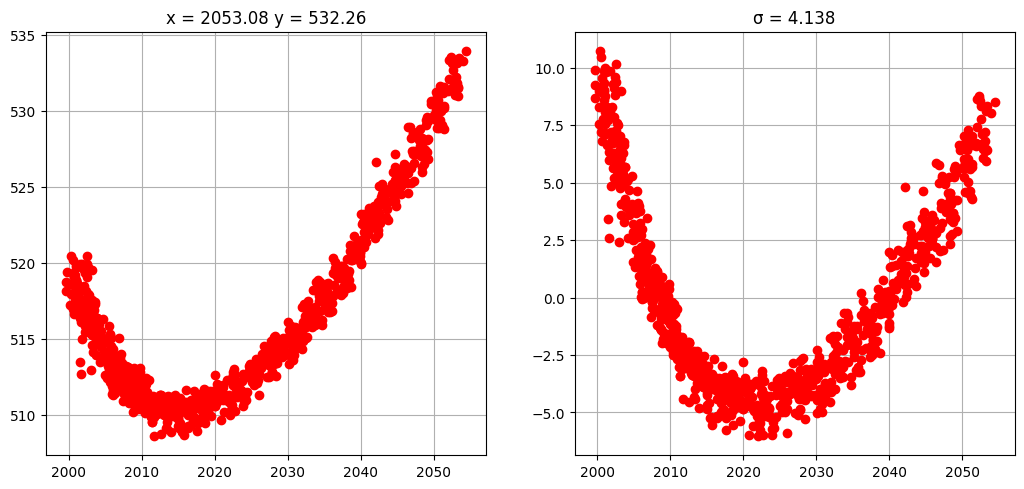

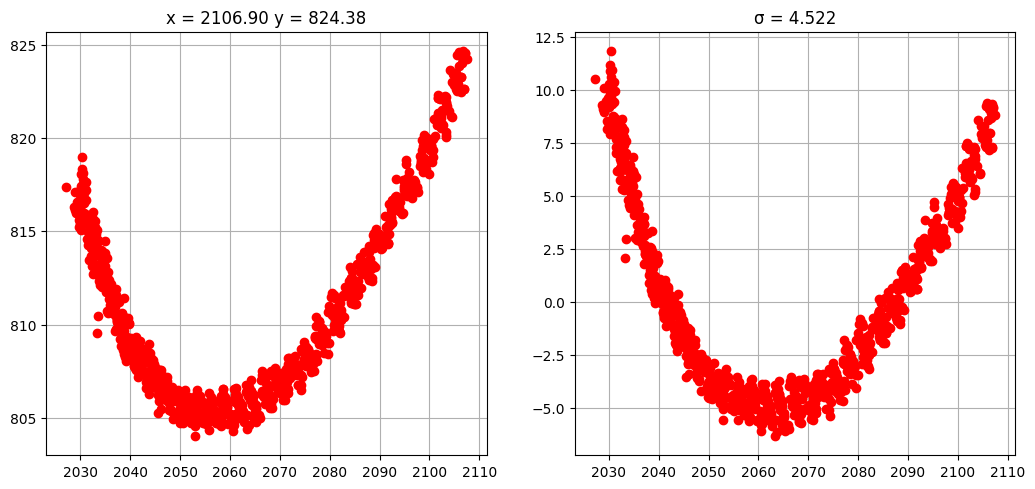

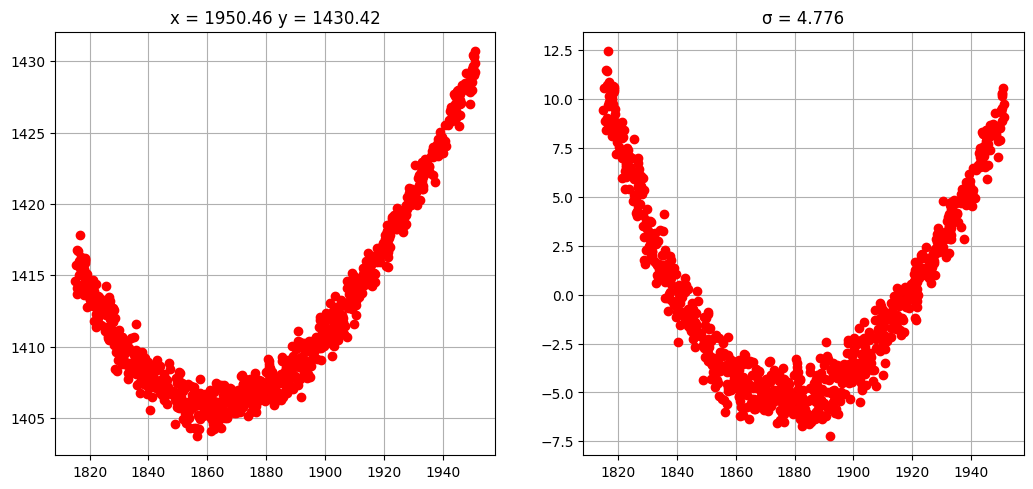

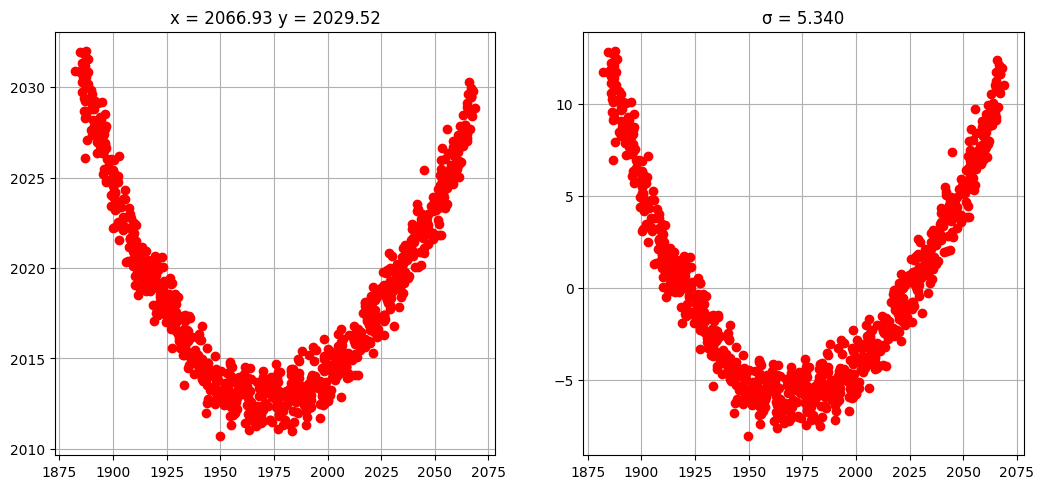

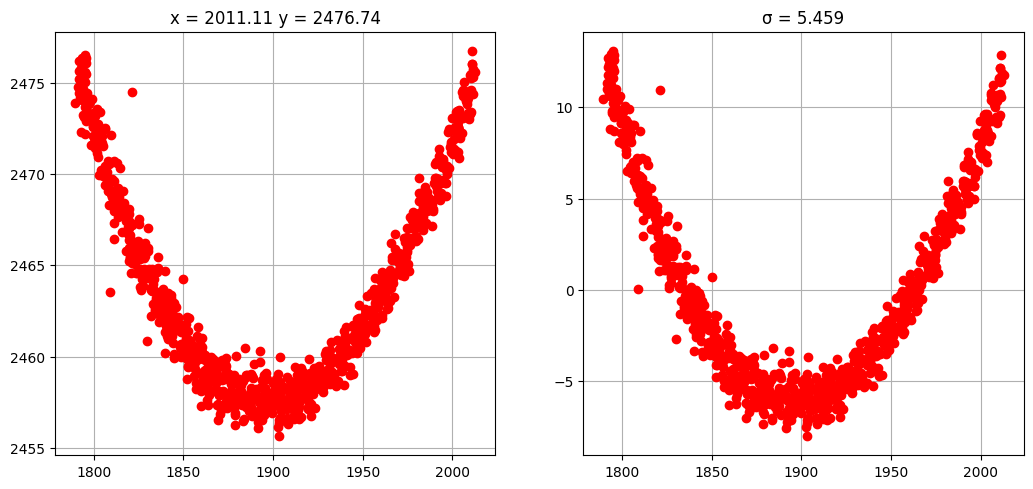

In [10]:
# step over evenly spaced positions in image, and pick nearest star for ploting.
step = 500
for x in range(step, nx, step):
    for y in range(step, ny, step):
        plot_residuals(x, y, table_list, nearest=True, large_resid=0.0) # only plot large residuals

In [11]:
# plot_residuals(158.65, 343.44, table_list, nearest=True)

## Reject stars

In [12]:
table_list_clean = reject_stars(table_list, residual_threshold=20.)

In [13]:
table_list_clean[-1]

xcentroid,ycentroid,xoffset,yoffset,xoffset_prev,yoffset_prev,ref_row,prev_row
float64,float64,float64,float64,float64,float64,int64,int64
1253.6769331406585,143.13616737583484,27.421606725650918,73.52174820850833,0.8483595543073079,-0.8065515072223945,5,0
436.41760047732515,208.57021180700647,24.898668110879896,130.2305228831149,-0.2899604895949892,0.4537803040890651,6,1
1143.794097278141,175.20458449033086,29.938010157851977,81.52943523696436,0.15594010626136878,-0.19810781498341612,9,2
1145.7658379792301,256.00472684566745,37.39594931963006,81.46198643442509,-0.54759007378766,-0.047302775093669425,12,3
347.48412961225824,313.2608638713791,33.213263911130866,137.2081129601919,0.9261256038357146,-0.7596518744906007,13,4
1100.919922173416,307.18453493889444,42.717591390545294,85.20730378313453,0.0258460651950827,0.12482599848794962,14,5
667.3935329609975,355.23466213167836,42.997775621669575,115.52814599373545,0.24947800112727236,0.05147226046949527,15,6
1009.077769161399,335.09918804955157,45.070520522748325,92.86365649713042,1.0875088888178652,2.147413833763892,16,7
2001.4594026624711,270.7828025950554,27.388811407374533,20.929131713123127,-0.30540881534921027,-0.10350979234976876,17,8


## Write cleaned tables

In [14]:
for i, tname_in in enumerate(file_list):
    tname_out = tname_in.replace('.offsets_table.fits','.offsets_table_clean.fits')
    
    table_list_clean[i].write(tname_out, overwrite=True)
    print(tname_out)

/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00362.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00363.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00364.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00365.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00366.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00367.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00368.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00369.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00370.offsets_table_clean.fits
/Users/busko/Projects/astrop

/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00474.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00475.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00476.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00477.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00478.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00479.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00480.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00481.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00482.offsets_table_clean.fits
/Users/busko/Projects/astrop

/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00552.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00553.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00554.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00555.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00556.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00557.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00558.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00559.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00560.offsets_table_clean.fits
/Users/busko/Projects/astrop

/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00631.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00632.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00633.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00634.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00635.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00636.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00637.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00638.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00639.offsets_table_clean.fits
/Users/busko/Projects/astrop

/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00710.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00711.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00712.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00713.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00714.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00715.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00716.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00717.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00718.offsets_table_clean.fits
/Users/busko/Projects/astrop

/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00797.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00798.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00799.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00800.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00801.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00802.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00803.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00804.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00805.offsets_table_clean.fits
/Users/busko/Projects/astrop

/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00886.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00887.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00888.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00889.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00890.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00891.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00892.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00893.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00894.offsets_table_clean.fits
/Users/busko/Projects/astrop

/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00974.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00975.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00976.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00977.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00978.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00979.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00980.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00981.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC00982.offsets_table_clean.fits
/Users/busko/Projects/astrop

/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01061.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01062.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01063.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01064.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01065.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01066.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01067.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01068.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01069.offsets_table_clean.fits
/Users/busko/Projects/astrop

/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01150.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01151.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01152.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01153.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01154.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01155.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01156.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01157.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01158.offsets_table_clean.fits
/Users/busko/Projects/astrop

/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01236.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01237.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01238.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01239.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01240.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01241.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01242.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01243.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm1s3200ISO/DSC01244.offsets_table_clean.fits
/Users/busko/Projects/astrop

## Check coverage

Plot remaining stars over image to see how much was removed, and where.

In [ ]:
plt.figure(figsize=[9, 6])
plt.imshow(imarray, vmin=-10, vmax=1000, cmap='binary')
plt.colorbar()

for table in table_list_clean:
    positions = [(x,y) for x,y in zip(table['xcentroid'], table['ycentroid'])]
    apertures = CircularAperture(positions, r=1.)
    _ = apertures.plot(color='red')

## Conclusions

Most of the residuals from a linear fit are of the order of a few tenths of a pixel (14 mm lens) or smaller than the PSF FWHM (135 mm lens). Depending on the position of the star on the sky, a linear fit may or may not be a good approximation, so that may account for a slight increase in the rms of the residuals. 

Overall the method seems to be satisfactory. 